# SMAI Assignment - 2

## Question 2: Gaussian Mixture Models

Resources: 
- https://youtu.be/qMTuMa86NzU
- https://youtu.be/ZBLyXgjBx3Q

Reference: https://scikit-learn.org/stable/modules/mixture.html 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

### Part 1: Gaussian Mixture Models

We'll attempt to solve the task of background subtraction using Gaussian Mixture Models. Before that, you will need to implement the Gaussian Mixture Model algorithm from scratch.

Some details: 
- Try to implement GMMs using Multi-variate Gaussian Distributions, the following tasks in the assignment are possible to implement using the Univariate version too but it might be bit inaccurate as explained below.
    - To clarify further, we could treat each pixel in our RGB image as our data point with [R, G, B] channels as the dimensions to the Multi-variate data point, and we would easily get predictions for each pixel location using Multi-variate approach.
    - Or, we could treat every single value in the given RGB image as a data point independent of what channel the belong to and consider them as Uni-variate data point, and get prediction using the Uni-variate approach.
    But this affects our prediction, since we can't simply make per pixel predtions anymore, because for every pixel location we would now have 3 different predictions.
    - To get around this, you could convert your image to Grayscale and then we would only have one channel/value corresponding to each pixel location, which would now allow us to use the Uni-variate approach for prediction, but this also means loss in information which would affect our quality of predictions.
    - Try to have a class based implementation of GMM, this would really help you in Background Subtraction task. You can get some general ideas on how to structure your class by looking at `sklearn.mixture.GaussianMixture` documentation and source code.
- The following code cell has a rough template to get you started with the implementation. You are free to change the structure of the code, this is just a suggestion to help you get started.


TLDR: You may implement the univariate version of GMMs, but it might not be as accurate as the multivariate version and it is recommended to try and implement the multivariate version.

In [2]:
#import libraries 
import pandas as pd
import numpy as np

- n_components : Number of Gaussian Mixture components to use in the model.
- max_iter : The number of EM iterations to perform.
- pi : Fraction of points assigned to each Gaussian.
- comp_names : Names of the components in the model.
- r matrix  : This is of the size len(X)*n component, basically r[i][j] is the probability of the i-th sample belonging to the j-th Gaussian component.

In [3]:
import numpy as np
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = [1/self.k] * self.k
        self.weights = np.full_like(X, fill_value=1/self.k)
        self.mu = [X[row_index, :] for row_index in np.random.randint(0, self.n, self.k)]
        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = np.sum(X * weight, axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X):
        self.initialize(X)
        for _ in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

    def predict_proba(self, X):
        likelihood = np.zeros((self.n, self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:, i] = distribution.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights

    def predict(self, X):
        weights = self.predict_proba(X)
        belongs_to=np.argmax(weights,axis=1)
        return belongs_to


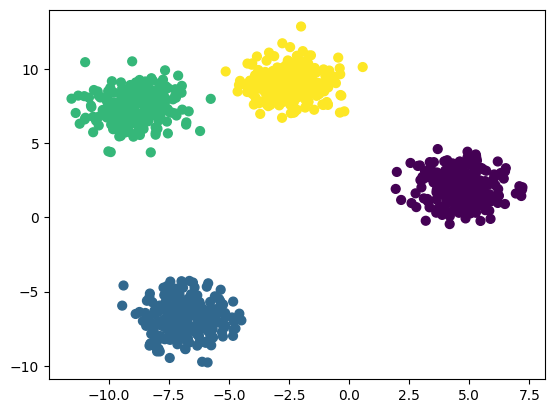

In [ ]:
# testing with the blobs
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=4, random_state=42)
gmm = GMM(k=4, max_iter=100)
gmm.fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')


### Part 2: Background Subtraction

![traffic](./videos/traffic.gif)

In this question, you are required to extract the background image from a given set of training frames, and use the extracted background to display foreground objects in the test frames by subtracting that background image and then thresholding it accordingly.

In this question, we are going to try different baselines to extract background from low resolution camera footage:

1. Frame Averaging:
    - Just take the average of every training frame, which gives us an approximate background image.
    
2. GMM Per Pixel:
    - We will maintain per pixel GMMs of 2 components, and then fit these GMMs considering every training from for its corresponding pixel.
    - And then use these GMMs to predict the pixel labels for every subsequent frame.
    - Most of the time, the Gaussian with the higher weight corresponds to the background.
    - We can implement this in a simpler way but with worse prediction results, you can extract a mean background image similar to the first baseline above.
    - To extract the Mean background image, we can assign values of the Means corresponding to the highest weighted Gaussian for each pixel.
    - This method is much simpler to implement but, this could give worse results.

#### Extracting Frames from videos

In [4]:
source_folder = 'videos'
video = 'traffic.gif'

source_path = f'./{source_folder}/{video}'

In [5]:
data_folder = 'frames'

frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"

In [ ]:
import os
import subprocess

# Set the path to ffmpeg executable
ffmpeg_path = r"C:\ffmpeg\ffmpeg.exe"

# Set the source_folder and video file
source_folder = 'videos'
video = 'traffic.gif'
source_path = f'./{source_folder}/{video}'

# Set the data_folder and frames_path
data_folder = 'frames'
frames_path = f"./{data_folder}/{video.rsplit('.', 1)[0]}"
os.makedirs(frames_path, exist_ok=True)

# Construct the command
command = f'{ffmpeg_path} -i "{source_path}" "{frames_path}/frame_%04d.png" > nul 2>&1'
# run this on terminal : ffmpeg -i "videos\traffic.gif" "frames\traffic\frame_%04d.png" > nul 2>&1 
# go the folder as well
# Execute the command using subprocess
subprocess.run(command, shell=True)


CompletedProcess(args='C:\\ffmpeg\\ffmpeg.exe -i "./videos/traffic.gif" "./frames/traffic/frame_%04d.png" > nul 2>&1', returncode=1)

#### Loading Frames

(80, 120, 160, 3)


(-0.5, 159.5, 119.5, -0.5)

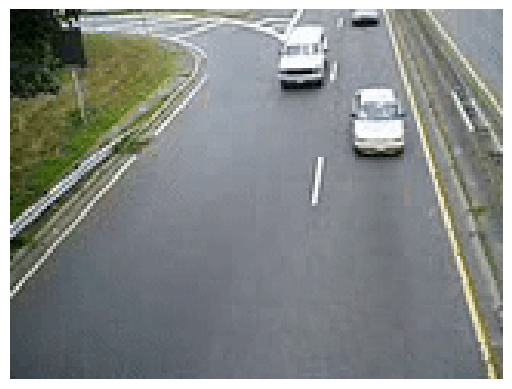

In [10]:
import glob
import cv2

frames = []

for file_path in sorted(glob.glob(f'{frames_path}/*.png', recursive = False)):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img = np.asarray(img, dtype=np.float64)
    img /= 255.0
    
    frames.append(img)
    
frames = np.asarray(frames, dtype=np.float64)
print(frames.shape)

# plot any one image say frames[0] it has dimennsion (120, 160, 3)

plt.imshow(frames[20])
plt.axis('off')


#### Splitting the data

In [7]:
from sklearn.model_selection import train_test_split

print(f'frame: {frames.shape}')

train_frames, test_frames = train_test_split(frames, train_size=0.6, shuffle=False) # Do Not Shuffle!

print(f'train_frames: {train_frames.shape}')
print(f'test_frames: {test_frames.shape}')

frame: (80, 120, 160, 3)
train_frames: (48, 120, 160, 3)
test_frames: (32, 120, 160, 3)


Note: You may use helper libraries like `imageio` for working with GIFs.

```python
import imageio

def make_gif(img_list, gif_path, fps=10):
    imageio.mimsave(gif_path, img_list, fps=fps) 
    return
```

#### Frame Averaging

Extract Background Image from the training data and display it.

(-0.5, 159.5, 119.5, -0.5)

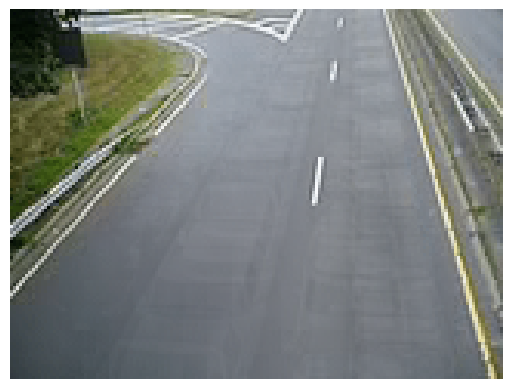

In [17]:
background_image = np.mean(train_frames*255, axis=0)
background_image = background_image.astype(np.uint8)
plt.imshow(background_image)
plt.axis('off')


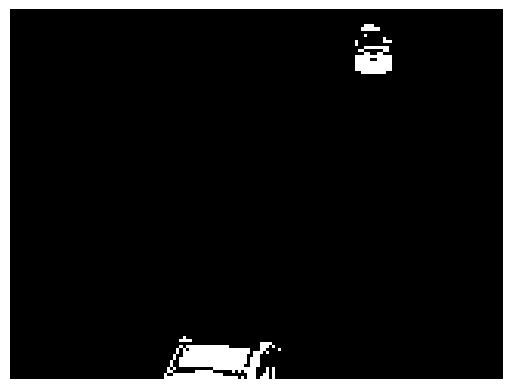

In [19]:
i=20
foregrounds = np.abs(test_frames[i]*255 - background_image)
foregrounds = np.array(foregrounds,dtype='uint8')
foregrounds = cv2.cvtColor(foregrounds, cv2.COLOR_BGR2GRAY)
threshold = 50
for i in range(foregrounds.shape[0]):
    for j in range(foregrounds.shape[1]):
        if foregrounds[i][j]<threshold:
            foregrounds[i][j]=0
        else:
            foregrounds[i][j]=255          
#binary = np.where(foregrounds > threshold, 255, 0).astype(np.uint8)
plt.imshow(foregrounds,cmap='gray')
plt.axis('off')
plt.show()

#### GMMs per pixel

Create Set of GMMs for every pixel and fit them considering every training frame

In [ ]:
# your code here
# now we need to consider set of GMM and fit them considerring every training frame

#### Extract Background Image from the trained model

In [ ]:
# your code here

### Outputs

You can use the helper functions given below to display and save frames as videos, feel free to change them accordingly.

In [ ]:
# helper functions

def display_frames(frames, fps=10.0):
    """
    Display the frames as a video.
    """
    eps = 0.0001
    
    wait_time = int(1000 // fps)
    
    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow("video", frame)
        k = cv2.waitKey(wait_time)

        if k == ord('q'):
            print("Quitting...")
            break
    
    cv2.destroyAllWindows()


def save_frames(frames, fps=10.0, output_path='./results', file_name='temp'):
    """
    Save the frames as a video.
    """
    eps = 0.0001
    
    frame_rate = float(fps)
    frame_size = (int(frames[0].shape[1]), int(frames[0].shape[0]))
    wait_time = int(1000 // fps)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    
    save_path = os.path.join(output_path, f"{file_name.rsplit('.', 1)[0]}.mp4")
    
    vid_wrt = cv2.VideoWriter(save_path, fourcc, frame_rate, frame_size)

    for frame in frames:
        frame = frame.astype(np.float64)
        frame = (frame - frame.min()) * 255 / (frame.max() - frame.min() + eps)
        frame = frame.astype(np.uint8)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        
        cv2.imshow('frame',frame)
        if cv2.waitKey(wait_time) & 0xFF == ord('q'):
            break
        
        vid_wrt.write(frame)

        
    vid_wrt.release()
    cv2.destroyAllWindows()

#### Frame Averaging

In [ ]:
# your output here

#### GMMs per pixel

In [ ]:
# your output here